# Computing the ACF

In this notebook we show how we can compute the ACF and show various examples to help build our intuition of how to interpret the ACF plots.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_context("talk")

# Computing the ACF manually for a white noise timeseries

The autocorrelation of a timeseries $y_t$ at a lag $k$ is given by:

$$ r_k =  \frac{\sum^{t=T}_{t=k+1}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum^{t=T}_{t=1}{(y_t - \bar{y})^2}}$$

Let's compute this manually on a time series of white noise where each observation is generated by random from a normal distribution so there is no predictive information in any historic point:

$$y_t = noise_t$$ where $$noise_{t}  \sim  N(mean, std)$$

We expect the autocorrelation to be small at all lags as each data point is completely independent of each other.

In [5]:
num_timesteps = 300 # Length of time series we want
np.random.seed(0) # Ensures we generate the same random numbers every time

y = np.random.normal(loc=0, scale=1, size=num_timesteps)
ts = pd.date_range(start='2000-01-01', periods=num_timesteps, freq='D')

white_noise = pd.DataFrame(data={'y': y}, index=ts)
white_noise.head()

,y
2000-01-01,1.764052
2000-01-02,0.400157
2000-01-03,0.978738
2000-01-04,2.240893
2000-01-05,1.867558


Text(0.5, 1.0, 'white noise')

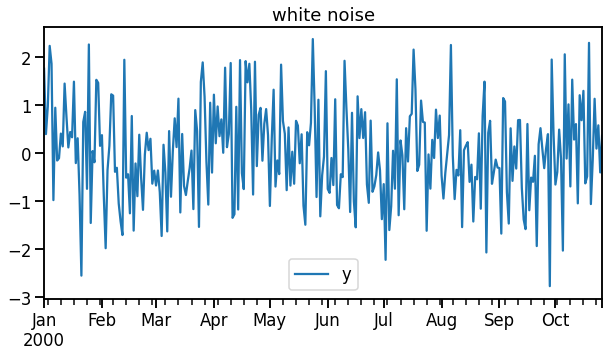

In [6]:
# Plot the time series
ax = white_noise.plot(figsize=[10, 5])
ax.set_title('white noise')

In [7]:
# Create a copy to preserve the original dataframe for later use
df_ = white_noise.copy() 

In [8]:
# Compute the lag of the target
lag = 1
df_[f"y_lag_{lag}"] = df_["y"].shift(periods=lag)
df_.head()

,y,y_lag_1
2000-01-01,1.764052,NaN
2000-01-02,0.400157,1.764052
2000-01-03,0.978738,0.400157
2000-01-04,2.240893,0.978738
2000-01-05,1.867558,2.240893


Note: It is because of the missing data introduced by the lag that we start the sum from k+1 in the numerator.

In [9]:
# Compute the numerator and denominator in the ACF formula
y_mean = df_["y"].mean() # Compute mean of y on entire dataset 

# Drop missing values in calculating the numerator
numerator = ((df_["y"] - y_mean) * (df_[f"y_lag_{lag}"] - y_mean)).sum()

# Use all the data for computing denominator
denominator = ((df_["y"] - y_mean) ** 2).sum()

# Compute the autocorrelation at the specified lag
r = numerator / denominator
print(r)

-0.02964688962835345


In [11]:
# Compute the autocorrelation for multiple lags
r = {}
for lag in range(0, 37):
    df_ = white_noise.copy()
    df_["y_lag"] = df_['y'].shift(lag)
    y_mean = df_["y"].mean()
    numerator = ((df_["y"] - y_mean) * (df_["y_lag"] - y_mean)).sum()
    denominator = ((df_["y"] - y_mean) ** 2).sum()
    r[lag] = numerator / denominator

acf_ = pd.Series(r)

In [12]:
acf_.head()

0    1.000000
1   -0.029647
2    0.051701
3    0.056755
4    0.004363
dtype: float64

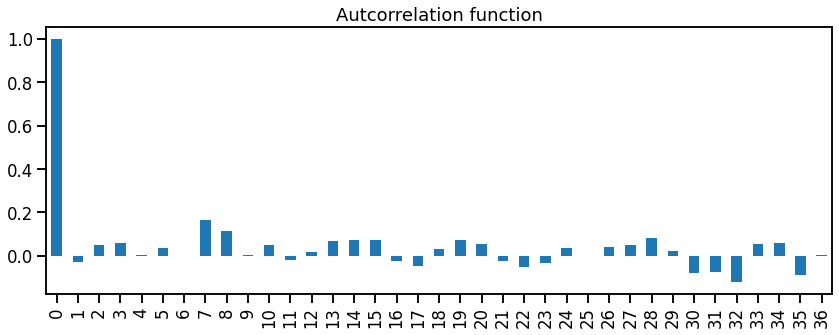

In [13]:
fig, ax = plt.subplots(figsize=[12, 5])
acf_.plot(kind="bar", ax=ax)
ax.set_title("Autcorrelation function")
plt.tight_layout()

# Compute the ACF for white noise using statsmodels

In [14]:
# Create a copy to preserve the original dataframe for later use
df_ = white_noise.copy() 

In [15]:
acf_ = acf(x=df_["y"], nlags=20)
acf_

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        , -0.02964689,  0.0517005 ,  0.05675462,  0.00436303,
        0.03528042, -0.00266454,  0.16528553,  0.11264096,  0.00461414,
        0.0512451 , -0.01728878,  0.01791833,  0.06893252,  0.07320845,
        0.07403495, -0.0241931 , -0.04691654,  0.03300885,  0.07272857,
        0.05298582])

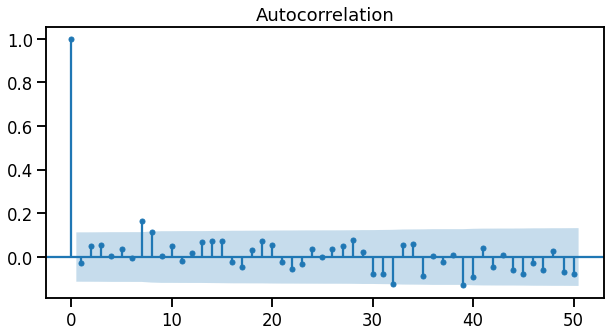

In [16]:
fig, ax = plt.subplots(figsize=[10, 5])
plot_acf(
    x=df_["y"],
    lags=50,
    ax=ax,
    alpha=0.05,
);

 - The autocorrelation is one at lag 0 as expected.
 - The autocorrelation at all other lags are not signficant. As expected from white noise.


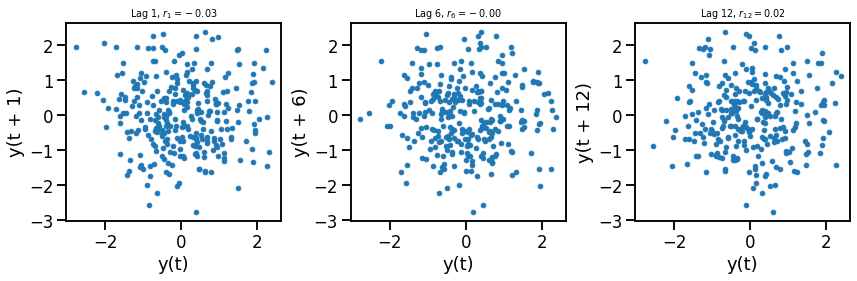

In [28]:
# Plot example lag plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])

with sns.plotting_context('paper'):
    pd.plotting.lag_plot(df_["y"], lag=1, ax=ax[0])
    ax[0].set_title(f"Lag 1, $r_1={acf_[1]:.2f}$")
    ax[0].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df_["y"], lag=6, ax=ax[1])
    ax[1].set_title(f"Lag 6, $r_6={acf_[6]:.2f}$")
    ax[1].ticklabel_format(style="sci", scilimits=(0, 0))

    pd.plotting.lag_plot(df_["y"], lag=12, ax=ax[2])
    ax[2].set_title(f"Lag 12, $r_{{12}}={acf_[12]:.2f}$")
    ax[2].ticklabel_format(style="sci", scilimits=(0, 0))

    plt.tight_layout()

We see clearly that there is no correlation in the lag plots.

Let's plot these together for convenience

In [31]:
def plot_ts_and_acf(timeseries, lags):
    with sns.plotting_context("paper"):
        layout = '''
                 AAABBB
                 CCDDEE
                 '''
        fig, axs = plt.subplot_mosaic(layout, constrained_layout=True, figsize=[10,5])
        # Plot time series
        timeseries.plot(y=['y'], ax=axs['A'])
        axs['A'].set_title('y')
        # Plot ACF
        plot_acf(x=timeseries, lags=50, ax=axs['B'], alpha=0.05)
        # Plot example lag plots with ACF values
        acf_ = acf(x=timeseries["y"], nlags=max(lags))
        pd.plotting.lag_plot(timeseries, lag=lags[0], ax=axs['C'])
        axs['C'].set_title(f"Lag {lags[0]}, $r({lags[0]})={acf_[lags[0]]:.2f}$")
        pd.plotting.lag_plot(timeseries, lag=lags[1], ax=axs['D'])
        axs['D'].set_title(f"Lag {lags[1]}, $r({lags[1]})={acf_[lags[1]]:.2f}$")
        pd.plotting.lag_plot(timeseries, lag=lags[2], ax=axs['E'])
        axs['E'].set_title(f"Lag {lags[2]}, $r({lags[2]})={acf_[lags[2]]:.2f}$")

    return ax

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


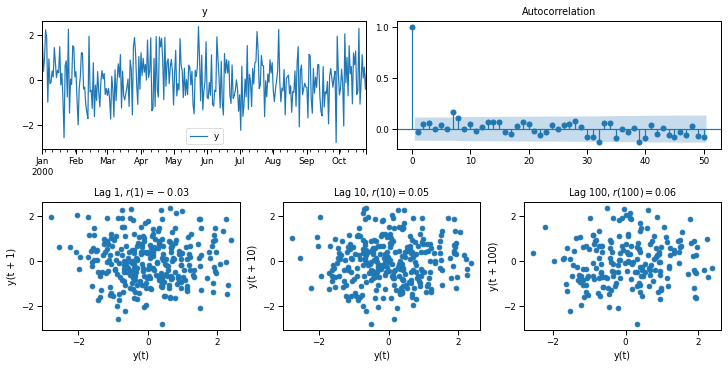

In [32]:
ax = plot_ts_and_acf(white_noise, lags=[1,10,100])

Now let's look at some timeseries with more structure and see what the ACF looks like.

# Time series with trend

In [33]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

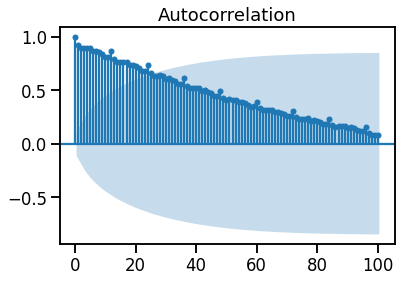

In [47]:
plot_acf(df['y'], lags=100);

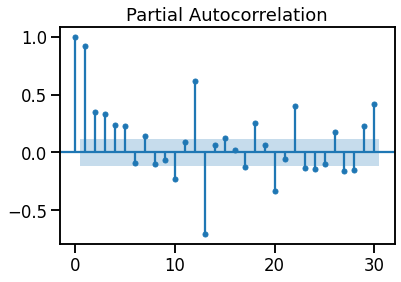

In [39]:
plot_pacf(df['y'], lags=30);

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 10)'>

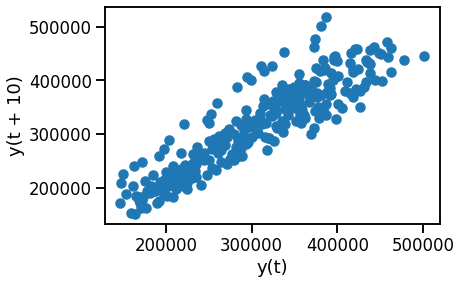

In [44]:
pd.plotting.lag_plot(df['y'], lag=10)

# Time series with lag 1 (aka AR(1) process)

We create a toy time series where there should be a correlation with the lag of the time series

$$y_t = \phi y_{{t-1}} + noise_t$$ where $$noise_{t}  \sim  N(mean, std)$$

We might think that this means there is only a correlation with lag 1 of the time series $y$ but we will see that is not the case. Also just for your information, the above is known as an AR(1) process where AR stands for autoregressive.

We can write the formula in terms of lags greater than 1 by feeding the formula back into itself. To simplify the point we're going to ignore the noise component for now: 

$$y_t = \phi y_{{t-1}} $$ 
$$y_t = \phi^2 y_{{t-2}} $$
$$y_t = \phi^3 y_{{t-3}} $$
$$...$$

This shows us that we can relate $y_t$ to lagged versions of itself for lags greater than 1. We see that data further in the past gets less weight (when $|\phi_1| < 1$ which is a constraint to ensure that the distant past does not get more weight than the recent past). This means that larger lags have less influence on $y_t$. We shall see this decrease in influence from lags further in the past will be reflected in the ACF.

In [290]:
# Initial parameters
num_timesteps = 1000 # Length of time series we want
np.random.seed(0) # Ensures we generate the same random numbers every time
phi = 0.9
ts = pd.date_range(start='2000-01-01', periods=num_timesteps, freq='D')

# Generate time series
y = np.zeros(num_timesteps)
for t in range(1, num_timesteps):
    noise = np.random.normal()
    y[t] = phi * y[t - 1] + noise

AR1 = pd.DataFrame(data={'y':y}, index=ts)

Text(0.5, 1.0, 'AR1')

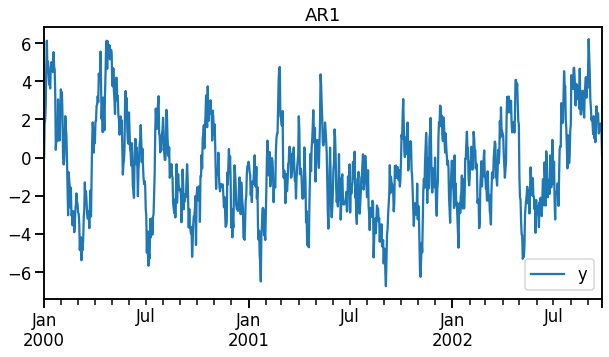

In [291]:
# Plot the time series
ax = AR1.plot(figsize=[10, 5])
ax.set_title('AR1')

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


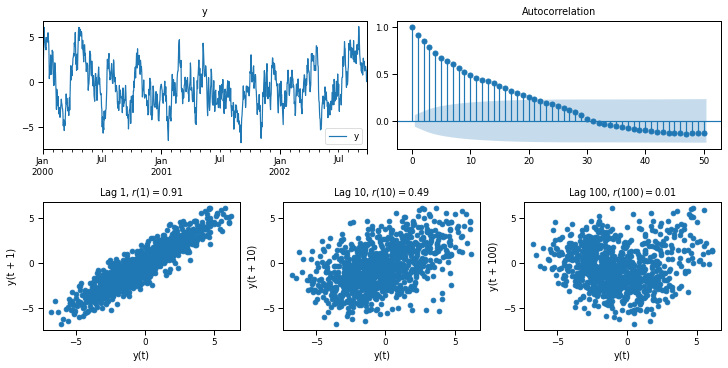

In [292]:
# Plot timeseries, ACF, and lags
ax = plot_ts_and_acf(timeseries=AR1, lags=[1,10,100])

- The ACF decreases exponentially with lag. As expected from the formula. The distant past has less influence on the future.
- There are significant autocorrelations after lag 1. There is a correlation between time t and a lag of t-k as shown by the formula.
- We see that there is autocorrelation for small lags but not large lags.

# Time series with lag p 


We create a toy time series where there should be a correlation with a specific lag of the time series

$$y_t = \phi y_{{t-p}} + noise_t$$ where $$noise_{t}  \sim  N(mean, std)$$

We might think that this means there is only a correlation with lag $p$ of the time series $y$ but we will see that is not the case.

We can write the formula in terms of lags greater than 1 by feeding the formula back into itself. To simplify the point we're going to ignore the noise component for now: 

$$y_t = \phi y_{{t-p}} $$ 
$$y_t = \phi^2 y_{{t-2p}} $$
$$y_t = \phi^3 y_{{t-3p}} $$
$$...$$

This shows us that we can relate $y_t$ to lagged versions of itself for lags greater than 1 *but* at integer multiples of $p$. We see that data further in the past gets less weight (when $|\phi_1| < 1$ which is a constraint to ensure that the distant past does not get more weight than the recent past). This means that larger lags have less influence on $y_t$. We shall see this decrease in influence from lags further in the past will be reflected in the ACF.

In [361]:
# Initial parameters
num_timesteps = 1000 # Length of time series we want
np.random.seed(0) # Ensures we generate the same random numbers every time
p = 10
phi = 0.9
ts = pd.date_range(start='2000-01-01', periods=num_timesteps, freq='D')

# Generate time series
y = np.zeros(num_timesteps)
for t in range(p, num_timesteps):
    noise = np.random.normal()
    y[t] = phi * y[t - p] + noise

ARP = pd.DataFrame(data={'y':y}, index=ts)

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


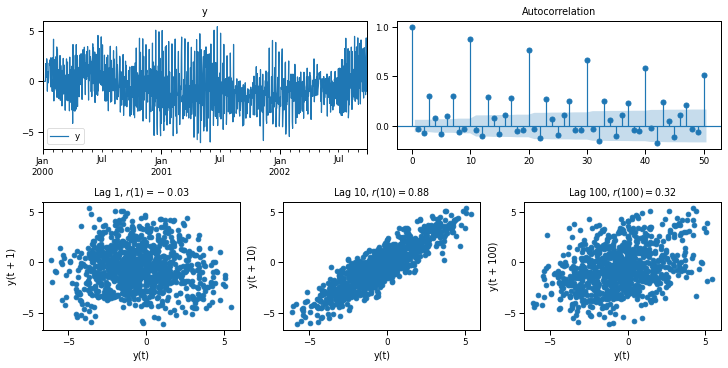

In [363]:
# Plot timeseries, ACF, and lags
ax = plot_ts_and_acf(timeseries=ARP, lags=[1,10,100])

- The ACF has a peak at every multiple of the lag $p$.
- The ACF decreases exponentially at each peak as expected from the formula. The distant past has less influence on the future.

# Time series with multiple lags 

Let's combine a lag of 1 and a lag of 10.

$$y_t = \phi_1 y_{{t-1}} + \phi_2 y_{{t-10}} + noise_t$$ where $$noise_{t}  \sim  N(mean, std)$$

In [398]:
# Initial parameters
num_timesteps = 1000 # Length of time series we want
np.random.seed(0) # Ensures we generate the same random numbers every time
phi_1 = 0.5
phi_2 = 0.3
ts = pd.date_range(start='2000-01-01', periods=num_timesteps, freq='D')

# Generate time series
y = np.zeros(num_timesteps)
for t in range(10, num_timesteps):
    noise = np.random.normal()
    y[t] = phi_1 * y[t-1] + phi_2 * y[t - 10]  + noise

ARmixed = pd.DataFrame(data={'y':y}, index=ts)

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


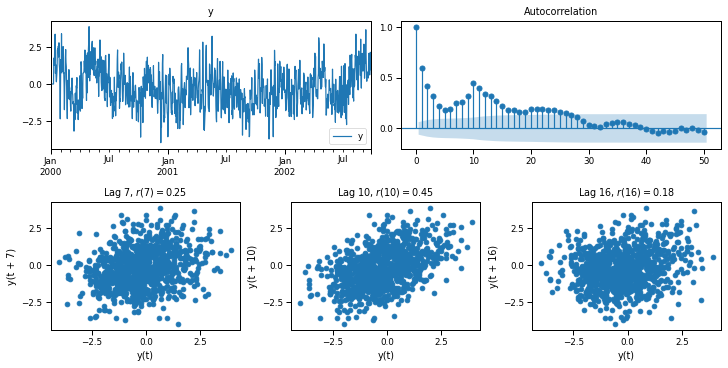

In [399]:
# Plot timeseries, ACF, and lags
ax = plot_ts_and_acf(timeseries=ARmixed, lags=[7,10,16])

# Trend

In [404]:
# Initial parameters
num_timesteps = 1000 # Length of time series we want
np.random.seed(0) # Ensures we generate the same random numbers every time
phi_1 = 0.5
phi_2 = 0.3
ts = pd.date_range(start='2000-01-01', periods=num_timesteps, freq='D')

# Generate time series
y = np.zeros(num_timesteps)
for t in range(10, num_timesteps):
    noise = np.random.normal()
    y[t] = phi_1 * y[t-1] + phi_2 * y[t - 10] + noise + t

ARmixed = pd.DataFrame(data={'y':y}, index=ts)

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


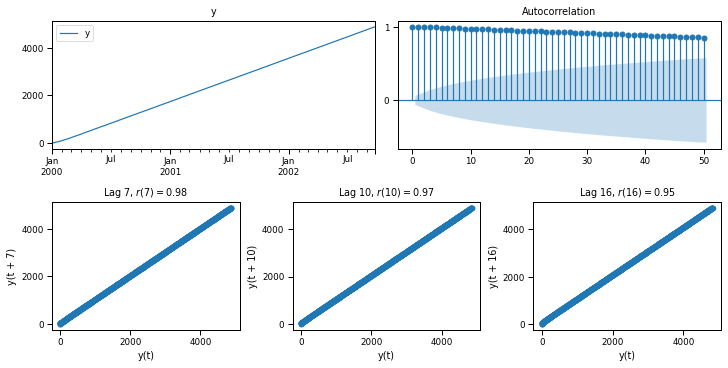

In [405]:
# Plot timeseries, ACF, and lags
ax = plot_ts_and_acf(timeseries=ARmixed, lags=[7,10,16])

# Seasonality

# Multiple seasonality

# Trend and multiple seasonality